# Plot Fisher information

Johann Brehmer, Kyle Cranmer, Marco Farina, Felix Kling, Duccio Pappadopulo, Josh Ruderman 2018

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import logging
import os

import madminer.core
from madminer.plotting import plot_fisher_information_contours_2d

logging.basicConfig(format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s', datefmt='%H:%M', level=logging.DEBUG)


19:40 matplotlib.pyplot    DEBUG   Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
base_dir = '/Users/johannbrehmer/work/projects/madminer/diboson_mining/'
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2/'

In [3]:
sample_dir = base_dir + 'data/samples/wgamma/'
card_dir = base_dir + 'cards/wgamma/'
ufo_model_dir = card_dir + 'SMWgamma_UFO'
run_card_dir = card_dir + 'run_cards/'
mg_process_dir = base_dir + 'data/mg_processes/wgamma/'
log_dir = base_dir + 'logs/wgamma/'
temp_dir = base_dir + 'data/temp'
delphes_dir = mg_dir + 'Delphes'
model_dir = base_dir + 'data/models/wgamma/'
result_dir = base_dir + 'data/results/wgamma/'

## Load Fisher information results

In [4]:
def load_data(ml_prefix = '', profiled=True):
    profile_suffix = # TODO
    
    
    # Ground truth
    infos  = [np.load(result_dir + 'information_parton.npy'),
              np.load(result_dir + 'information_xsec_tight.npy')]
    covs   = [np.load(result_dir + 'information_covariance_parton.npy'),
              np.load(result_dir + 'information_covariance_xsec_tight.npy')]
    labels = ['parton', 'xsec']
    colors = ['black', '0.5']
    lss    = [':', ':']
    
    # Histos
    histo_filenames = ['phi', 'deltaphi_lv', 'met', 'ptl', 'pta', 'deltaphi_la', ]
    histo_labels    = [r'$\varphi$', r'$\Delta\phi_{\ell\nu}$', 'MET', r'$p_{T,\ell}$', r'$p_{T,\gamma}$', r'$\Delta\phi_{\ell\gamma}$']
    histo_colors    = ['mediumblue', 'steelblue', 'dodgerblue', 'deepskyblue', 'cornflowerblue', 'b']
    histo_lss       = ['--']*10

    for hfilename, hlabel, hcolor, hls in zip(histo_filenames, histo_labels, histo_colors, histo_lss):
        infos.append(
            np.load(result_dir + 'information_histo_{}_tight.npy'.format(hfilename))
        )
        covs.append(
            np.load(result_dir + 'information_covariance_histo_{}_tight.npy'.format(hfilename))
        )
        labels.append(hlabel)
        colors.append(hcolor)
        lss.append(hls)
        
    # ML
    ml_filenames = ['full', 'full_infomode', 'minimal', 'full_tight', 'minimal_tight', 'phi_tight', 'full_shuffled']
    ml_labels    = ['full', 'full (I)', 'minimal', 'cuts', 'cuts min', r'$\varphi$', r'shuffled']
    ml_colors    = ['#CC002E', 'firebrick', 'orangered', 'lightcoral', 'r', 'chocolate', 'lightsalmon']
    ml_lss       = ['-', '-', '-', '-.', '-.', '--', ':']

    for hfilename, hlabel, hcolor, hls in zip(ml_filenames, ml_labels, ml_colors, ml_lss):
        infos.append(
            np.load(result_dir + 'information_{}{}.npy'.format(hfilename, ml_prefix))
        )
        covs.append(
            np.load(result_dir + 'information_covariance_{}{}.npy'.format(hfilename, ml_prefix))
        )
        labels.append(hlabel)
        colors.append(hcolor)
        lss.append(hls)
        
    return infos, covs, labels, colors, lss


In [5]:
infos, covs, labels, colors, lss = load_data('')

for i, (label, info, cov) in enumerate(zip(labels,infos, covs)):
    print(
        '{:2} {:10.10s}  I_00 = {:7.0f} +/- {:7.0f}\n               I_11 = {:7.0f} +/- {:7.0f}'.format(i, label, info[0,0], cov[0,0,0,0]**0.5, info[1,1], cov[1,1,1,1]**0.5)
    )

 0 parton      I_00 = 2459509 +/-  128168
               I_11 = 2492758 +/-  126232
 1 xsec        I_00 =       0 +/-       0
               I_11 =       8 +/-       2
 2 $\varphi$   I_00 =  369187 +/-    1709
               I_11 =     936 +/-      30
 3 $\Delta\ph  I_00 =  356723 +/-    1737
               I_11 =     133 +/-      15
 4 MET         I_00 =     475 +/-      14
               I_11 =     117 +/-      19
 5 $p_{T,\ell  I_00 =    1921 +/-      44
               I_11 =      86 +/-      13
 6 $p_{T,\gam  I_00 =     106 +/-      12
               I_11 =     191 +/-      17
 7 $\Delta\ph  I_00 =   78402 +/-     509
               I_11 =     114 +/-      11
 8 full        I_00 =  997891 +/-   65233
               I_11 =   20275 +/-     918
 9 full (I)    I_00 =  845623 +/-   27612
               I_11 =    5427 +/-     791
10 minimal     I_00 = 1131241 +/-   70368
               I_11 =   36781 +/-    1900
11 cuts        I_00 =  974872 +/-  102415
               I_11 =   51501 +/- 

## Plotting function

In [6]:
def make_plot(ml_prefix = '', indices=None, xmax=0.004):
    infos, covs, labels, colors, lss = load_data(ml_prefix)
    
    if indices is not None:
        infos = [infos[i] for i in indices]
        covs = [covs[i] for i in indices]
        labels = [labels[i] for i in indices]
        colors = [colors[i] for i in indices]
        lss = [lss[i] for i in indices]

    fig = plot_fisher_information_contours_2d(
        fisher_information_matrices=infos,
        fisher_information_covariances=covs,
        contour_distance=1.,
        xrange=(-xmax,xmax),
        yrange=(-xmax,xmax),
        xlabel=r'$f_{WWW}$',
        ylabel=r'$f_{\tilde{W}WW}$',
        linestyles=lss,
        colors=colors,
        resolution=600,
        inline_labels=labels
    )
    
    return fig


## Plots

05:47 root                 DEBUG   Std: [[3.7044564  3.69275881 3.68111079 ... 3.29884025 3.31082457 3.32286523]
 [3.69146815 3.67976009 3.66810164 ... 3.28871249 3.30071286 3.31276954]
 [3.67853386 3.6668153  3.65514638 ... 3.27863458 3.29065096 3.30272361]
 ...
 [3.30272361 3.29065096 3.27863458 ... 3.65514638 3.6668153  3.67853386]
 [3.31276954 3.30071286 3.28871249 ... 3.66810164 3.67976009 3.69146815]
 [3.32286523 3.31082457 3.29884025 ... 3.68111079 3.69275881 3.7044564 ]]
05:47 root                 DEBUG   Std: [[0.03285714 0.0326617  0.03246686 ... 0.02570556 0.02587465 0.02604436]
 [0.03283349 0.0326381  0.0324433  ... 0.02570159 0.02587073 0.02604048]
 [0.03280987 0.03261452 0.03241978 ... 0.02569768 0.02586686 0.02603665]
 ...
 [0.02603665 0.02586686 0.02569768 ... 0.03241978 0.03261452 0.03280987]
 [0.02604048 0.02587073 0.02570159 ... 0.0324433  0.0326381  0.03283349]
 [0.02604436 0.02587465 0.02570556 ... 0.03246686 0.0326617  0.03285714]]
05:47 root                 DEBUG

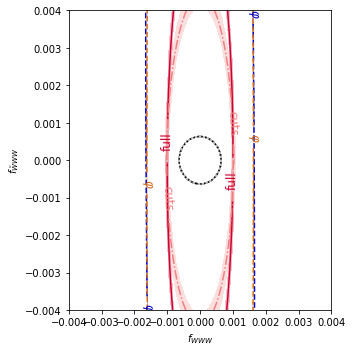

In [14]:
fig = make_plot('', xmax=0.004, indices=[0,2,8,11,13])

plt.savefig("../../figures/wgamma/information_wgamma.pdf")

05:43 root                 DEBUG   Std: [[2315.28524782 2307.97425365 2300.69424597 ... 2061.77515485
  2069.26535408 2076.79077172]
 [2307.16759362 2299.85005585 2292.56352409 ... 2055.44530624
  2062.9455385  2070.48096276]
 [2299.08366257 2291.75956197 2284.4664866  ... 2049.1466104
  2056.65684928 2064.20225337]
 ...
 [2064.20225337 2056.65684928 2049.1466104  ... 2284.4664866
  2291.75956197 2299.08366257]
 [2070.48096276 2062.9455385  2055.44530624 ... 2292.56352409
  2299.85005585 2307.16759362]
 [2076.79077172 2069.26535408 2061.77515485 ... 2300.69424597
  2307.97425365 2315.28524782]]
05:43 root                 DEBUG   Std: [[20.53571417 20.41356149 20.29178591 ... 16.06597231 16.17165749
  16.27772368]
 [20.52093112 20.39880979 20.2770656  ... 16.06349441 16.16920583
  16.27529827]
 [20.50616613 20.38407613 20.26236329 ... 16.06105091 16.16678857
  16.27290727]
 ...
 [16.27290727 16.16678857 16.06105091 ... 20.26236329 20.38407613
  20.50616613]
 [16.27529827 16.16920583 16.

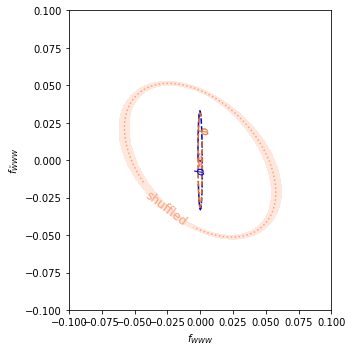

In [8]:
fig = make_plot('', xmax=0.1, indices=[0,2,11,13,14])

